In [3]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns 
import scipy.stats as sm 
import warnings
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn import linear_model
import xgboost
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

Trading rule that uses buy-and-hold, long-short, or day trade and generated trading signls using the above models . Compared their PnL.

In [4]:
#importing the data of the stock using the API_KEY that's why i am not taking start and end date 
import pandas_datareader as pdr
from alpha_vantage.timeseries import TimeSeries

key = 'SJNDG3FXMS6F62L0'

ts = TimeSeries(key = key,output_format='pandas')

data_frame, meta_data = ts.get_monthly_adjusted('TTM')

data_frame

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount
date,,,,,,,
2023-05-12,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
2023-04-28,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
2023-03-31,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
2023-02-28,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
2023-01-31,23.40,25.93,22.61,25.14,25.1400,32189809.0,0.0
...,...,...,...,...,...,...,...
2005-02-28,11.35,11.64,10.66,10.88,9.2084,4014900.0,0.0
2005-01-31,12.22,12.25,10.45,11.63,9.8431,5082700.0,0.0
2004-12-31,11.00,12.18,10.71,11.92,10.0886,7659800.0,0.0


In [5]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, bootstrap=True, criterion='squared_error')
xgb_model = xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators=20, learning_rate = 0.05)

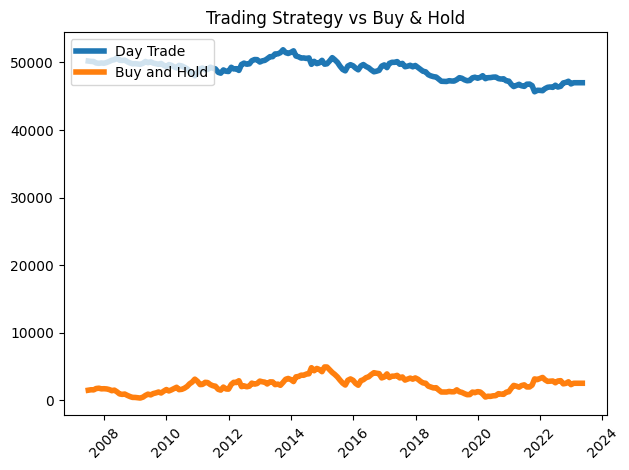

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Rename columns to simpler names
data_frame = data_frame.reset_index()
data_frame.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividend']

# Convert 'Date' to datetime
data_frame['Date'] = pd.to_datetime(data_frame['Date'])

# Sort by date
data_frame = data_frame.sort_values('Date').reset_index(drop=True)

# Define rolling window and horizon
win = 12  # 12 months
horizon = 1
position = 100
start = pd.Timestamp('2007-05-01')  # Adjust if necessary

# Find the start index
train_start = data_frame[data_frame['Date'] >= start].index[0]

# Initialize dictionaries
y_pred, y_test = {}, {}
signal, gain_loss, balance = {}, {}, {}
balance[train_start] = 50000

# Iterate over data
for today in range(train_start, len(data_frame) - 1):
    yesterday = today - 1
    tomorrow = today + 1

    if yesterday - win < 0:
        continue  # Not enough data for rolling window

    # Features (use OHLC + Volume)
    X_train = data_frame.iloc[yesterday - win : yesterday][['Open', 'High', 'Low', 'Close', 'Volume']]
    y_train = data_frame['Adj Close'].iloc[today - win : today]

    X_test = data_frame.iloc[today : today + 1][['Open', 'High', 'Low', 'Close', 'Volume']]

    # Fit your model (assuming xgb_model is already defined and imported)
    xgb_model.fit(X_train, y_train)
    y_pred[tomorrow] = xgb_model.predict(X_test)[0]
    y_test[tomorrow] = data_frame['Open'].iloc[tomorrow]

    if y_pred[tomorrow] >= y_test[tomorrow]:
        signal[tomorrow] = 1
        gain_loss[tomorrow] = -position * data_frame['Open'].iloc[tomorrow] + position * data_frame['Close'].iloc[tomorrow]
    else:
        signal[tomorrow] = -1
        gain_loss[tomorrow] = position * data_frame['Open'].iloc[tomorrow] - position * data_frame['Close'].iloc[tomorrow]

    balance[tomorrow] = balance[today] + gain_loss[tomorrow]

# Remove initial balance key
del balance[train_start]

# Convert dicts to DataFrames
signal = pd.DataFrame.from_dict(signal, orient='index', columns=['signal'])
gain_loss = pd.DataFrame.from_dict(gain_loss, orient='index', columns=['gain_loss'])
balance = pd.DataFrame.from_dict(balance, orient='index', columns=['balance'])

# Combine all metrics
xyx = pd.concat([signal, gain_loss, balance], axis=1)
xyx['Date'] = data_frame.loc[xyx.index, 'Date']
xyx['buy_hold'] = data_frame['Adj Close'].loc[xyx.index].values * position
xyx.set_index('Date', inplace=True)

# Plot
plt.plot(xyx['balance'], linewidth=4, label='Day Trade')
plt.plot(xyx['buy_hold'], linewidth=4, label='Buy and Hold')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title("Trading Strategy vs Buy & Hold")
plt.tight_layout()
plt.show()


In [7]:
print(f"\nDate: {today}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")


Date: 222
X_train shape: (12, 5), y_train shape: (12,)
X_test shape: (1, 5)


In [8]:
print(xyx[['balance', 'buy_hold']].head(10))
print(xyx[['balance', 'buy_hold']].tail(10))


            balance  buy_hold
Date                         
2007-06-29  50213.0   1485.12
2007-07-31  50158.0   1551.15
2007-08-31  50144.0   1533.06
2007-09-28  49924.0   1731.13
2007-10-31  49876.0   1781.78
2007-11-30  49924.0   1688.62
2007-12-31  49887.0   1705.81
2008-01-31  50000.0   1673.25
2008-02-29  50149.0   1584.61
2008-03-31  50337.0   1412.76
            balance  buy_hold
Date                         
2022-08-31  46476.5    2900.0
2022-09-30  46967.5    2426.0
2022-10-31  47057.5    2501.0
2022-11-30  47217.5    2730.0
2022-12-30  46828.5    2311.0
2023-01-31  47002.5    2514.0
2023-02-28  47002.5    2514.0
2023-03-31  47002.5    2514.0
2023-04-28  47002.5    2514.0
2023-05-12  47002.5    2514.0


This is my data of the trade done through this 

In [11]:
data_frame

,index,Date,Open,High,Low,Close,Adj Close,Volume,Dividend
0,0,2004-10-29,9.14,9.66,8.73,9.25,7.8288,4772900.0,0.0
1,1,2004-11-30,9.20,11.19,9.10,11.13,9.4200,5777800.0,0.0
2,2,2004-12-31,11.00,12.18,10.71,11.92,10.0886,7659800.0,0.0
3,3,2005-01-31,12.22,12.25,10.45,11.63,9.8431,5082700.0,0.0
4,4,2005-02-28,11.35,11.64,10.66,10.88,9.2084,4014900.0,0.0
...,...,...,...,...,...,...,...,...,...
219,219,2023-01-31,23.40,25.93,22.61,25.14,25.1400,32189809.0,0.0
220,220,2023-02-28,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
221,221,2023-03-31,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
222,222,2023-04-28,25.14,25.14,25.14,25.14,25.1400,0.0,0.0


In [12]:
data = data_frame  # renaming

print(data.head())  # confirm it's the same


   index       Date   Open   High    Low  Close  Adj Close     Volume  \
0      0 2004-10-29   9.14   9.66   8.73   9.25     7.8288  4772900.0   
1      1 2004-11-30   9.20  11.19   9.10  11.13     9.4200  5777800.0   
2      2 2004-12-31  11.00  12.18  10.71  11.92    10.0886  7659800.0   
3      3 2005-01-31  12.22  12.25  10.45  11.63     9.8431  5082700.0   
4      4 2005-02-28  11.35  11.64  10.66  10.88     9.2084  4014900.0   

   Dividend  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


In [13]:
print(data.columns)


Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividend'],
      dtype='object')


In [14]:


#define buy and hold strategy 
def buy_and_hold(data):
    entry_price = data['Open'].iloc[0]
    exit_price = data['Close'].iloc[-1]
    pnl = (exit_price - entry_price) * (100 / entry_price)
#assuming buying 100 shares 
    return pnl

#define long short strategy 
def long_short(data):
    entry_price = data['Open'].iloc[0]
    exit_price = data['Close'].iloc[-1]
    pnl = (exit_price - entry_price) * (100 / entry_price) #assuming buying 100 shares
    return pnl 

#define day trading strategy 
def day_trading(data):
    pnl = 0 
    for i in range(1, len(data)):
        if data['Open'].iloc[i] > data['Close'].iloc[i-1]:
            pnl += (data['Close'].iloc[i] - data['Open'].iloc[i]) * (100 / data['Open'].iloc[i])  #assuming buying 100 shares
        elif data['Open'].iloc[i] < data['Close'].iloc[i-1]:
            pnl -= (data['Open'].iloc[i] - data['Close'].iloc[i]) * (100 / data['Open'].iloc[i])
    return pnl

#calculate Pnl for each strategy 
pnl_buy_and_hold = buy_and_hold(data)
pnl_long_short = long_short(data)
pnl_day_trading = day_trading(data)

#Print Pnl for each strategy 
print("Profit nd Loss for Buy-and-Hold strategy: ", pnl_buy_and_hold)
print("Profit and Loss for Long-Short strategy: ", pnl_long_short)
print("Profit and Loss for Day Trading strategy: ",pnl_day_trading)


Profit nd Loss for Buy-and-Hold strategy:  175.054704595186
Profit and Loss for Long-Short strategy:  175.054704595186
Profit and Loss for Day Trading strategy:  184.16825533815611


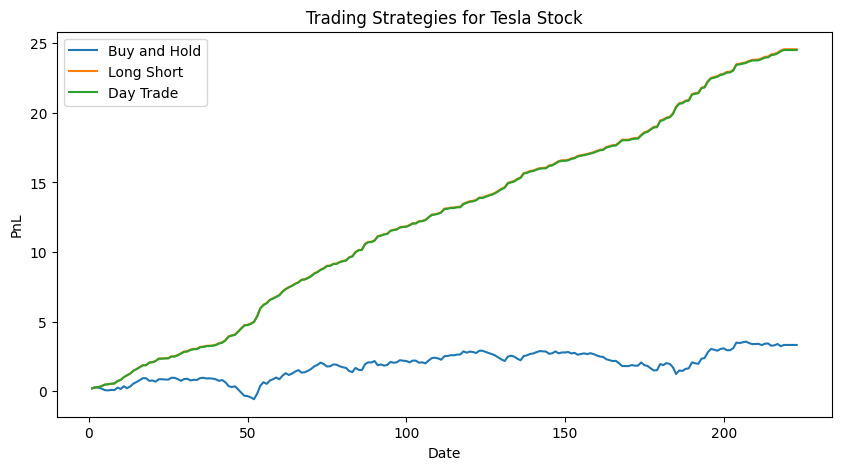

In [16]:
# Calculate daily returns
data['Daily_Returns'] = data['Close'].pct_change()

# Buy-and-hold strategy
data['Buy_and_Hold'] = data['Daily_Returns'].cumsum()

# Long-short strategy
data['Long_Short'] = np.where(data['Daily_Returns'] > 0, 1, -1)
data['Long_Short_Returns'] = data['Long_Short'] * data['Daily_Returns']
data['Long_Short_PnL'] = data['Long_Short_Returns'].cumsum()

# Day trade strategy
data['Day_Trade'] = np.where(data['Daily_Returns'] > 0.01, 1, np.where(data['Daily_Returns'] < -0.01, -1, 0))
data['Day_Trade_Returns'] = data['Day_Trade'] * data['Daily_Returns']
data['Day_Trade_PnL'] = data['Day_Trade_Returns'].cumsum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data['Buy_and_Hold'], label='Buy and Hold')
plt.plot(data['Long_Short_PnL'], label='Long Short')
plt.plot(data['Day_Trade_PnL'], label='Day Trade')
plt.title('Trading Strategies for Tesla Stock')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.show()

Final capital for Moving Average crossover strategy: 1850.9775229007541
Final capital for Bollinger Bands strategy: 7757.58406814793
Final capital for RSI strategy: 10891.699404510273
Total Trades (MA, BB, RSI): 299 8 23


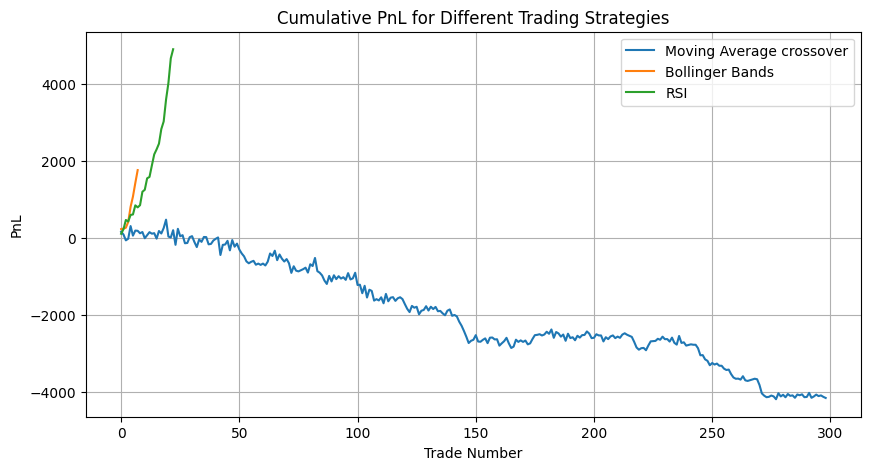

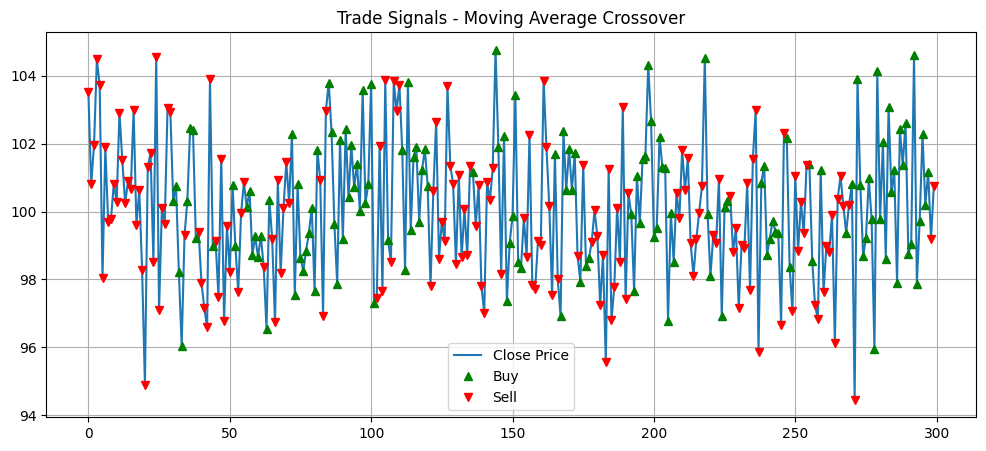

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Technical Indicator Calculation ===
def calculate_indicators(data):
    # Moving Average Crossover (10/20)
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['MACrossover'] = np.where(data['MA_10'] > data['MA_20'], 1, -1)

    # Bollinger Bands (shorter window = more trades)
    window = 10
    data['MA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['UpperBand'] = data['MA'] + (data['STD'] * 2)
    data['LowerBand'] = data['MA'] - (data['STD'] * 2)
    data['BBSignal'] = np.where(data['Close'] < data['LowerBand'], 1,
                         np.where(data['Close'] > data['UpperBand'], -1, 0))

    # RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=6).mean()  # smaller window
    loss = -delta.where(delta < 0, 0).rolling(window=6).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    data['RSISignal'] = np.where(data['RSI'] > 70, -1,
                          np.where(data['RSI'] < 30, 1, 0))

    return data

# === Backtesting Function ===
def backtest_strategy(data, signal_column, initial_capital=6000, hold_days=3):
    position = None
    capital = initial_capital
    pnl = []
    position_size = 0
    entry_price = 0
    entry_index = 0

    for i in range(len(data)):
        signal = data[signal_column].iloc[i]

        # Exit if max hold time reached
        if position is not None and (i - entry_index >= hold_days):
            exit_price = data['Close'].iloc[i]
            if position == 'long':
                pnl.append((exit_price - entry_price) * position_size)
                capital += (exit_price - entry_price) * position_size
            elif position == 'short':
                pnl.append((entry_price - exit_price) * position_size)
                capital += (entry_price - exit_price) * position_size
            position = None

        # Close if new signal in opposite direction
        elif position is not None and signal != 0:
            exit_price = data['Close'].iloc[i]
            if position == 'long':
                pnl.append((exit_price - entry_price) * position_size)
                capital += (exit_price - entry_price) * position_size
            elif position == 'short':
                pnl.append((entry_price - exit_price) * position_size)
                capital += (entry_price - exit_price) * position_size
            position = None

        # Open a new trade
        if position is None and signal != 0:
            position = 'long' if signal == 1 else 'short'
            entry_price = data['Close'].iloc[i]
            position_size = capital / entry_price
            entry_index = i

    return capital, pnl

# === Example Data (replace with your own) ===
# You should replace this with real market data
np.random.seed(0)
data = pd.DataFrame({'Close': np.random.normal(loc=100, scale=2, size=300)})

# === Run Calculations ===
data = calculate_indicators(data)

# === Backtest All Strategies ===
capital_MA, pnl_MA = backtest_strategy(data, 'MACrossover')
capital_BB, pnl_BB = backtest_strategy(data, 'BBSignal')
capital_RSI, pnl_RSI = backtest_strategy(data, 'RSISignal')

print("Final capital for Moving Average crossover strategy:", capital_MA)
print("Final capital for Bollinger Bands strategy:", capital_BB)
print("Final capital for RSI strategy:", capital_RSI)
print("Total Trades (MA, BB, RSI):", len(pnl_MA), len(pnl_BB), len(pnl_RSI))

# === Plot Cumulative PnL ===
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pnl_MA), label='Moving Average crossover')
plt.plot(np.cumsum(pnl_BB), label='Bollinger Bands')
plt.plot(np.cumsum(pnl_RSI), label='RSI')
plt.title('Cumulative PnL for Different Trading Strategies')
plt.xlabel('Trade Number')
plt.ylabel('PnL')
plt.legend()
plt.grid(True)
plt.show()

# === Optional: Plot Buy/Sell Signals for one strategy ===
plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['Close'][data['MACrossover'] == 1], '^', label='Buy', color='green')
plt.plot(data['Close'][data['MACrossover'] == -1], 'v', label='Sell', color='red')
plt.title('Trade Signals - Moving Average Crossover')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
print("MACrossover signals:", data['MACrossover'].value_counts())
print("BBSignal signals:", data['BBSignal'].value_counts())
print("RSISignal signals:", data['RSISignal'].value_counts())


MACrossover signals: MACrossover
-1    161
 1    139
Name: count, dtype: int64
BBSignal signals: BBSignal
 0    292
 1      5
-1      3
Name: count, dtype: int64
RSISignal signals: RSISignal
 0    277
 1     16
-1      7
Name: count, dtype: int64


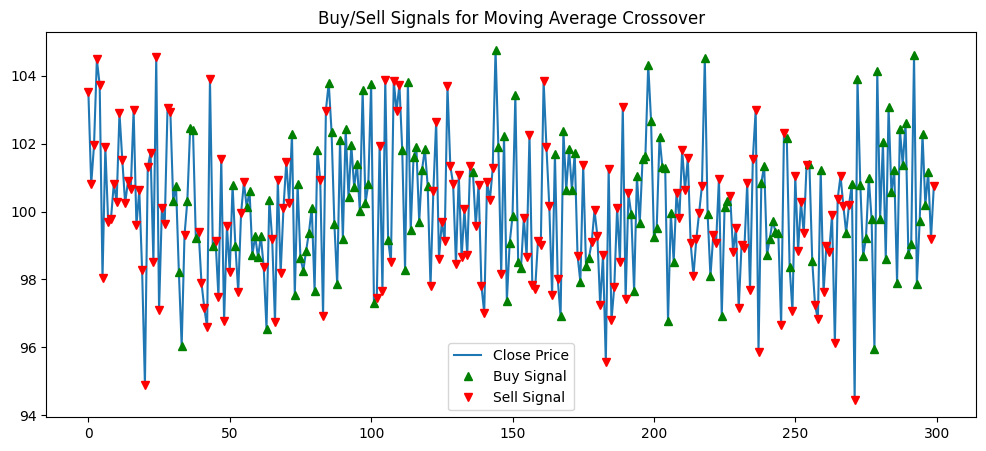

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['Close'][data['MACrossover'] == 1], '^', label='Buy Signal', color='green')
plt.plot(data['Close'][data['MACrossover'] == -1], 'v', label='Sell Signal', color='red')
plt.title('Buy/Sell Signals for Moving Average Crossover')
plt.legend()
plt.show()


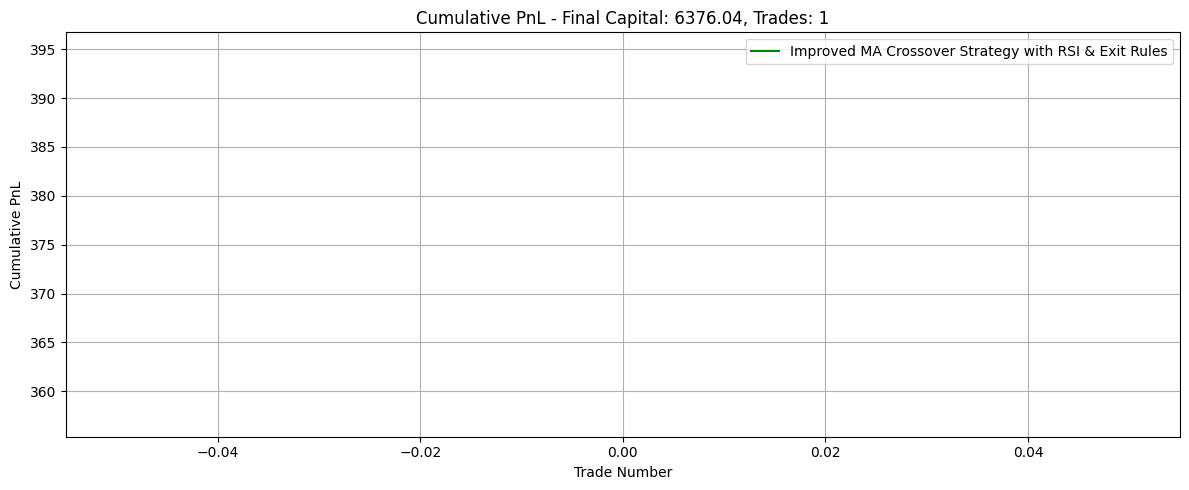

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic Close prices
np.random.seed(42)
n = 300
prices = np.cumsum(np.random.randn(n)) + 100
data = pd.DataFrame({'Close': prices})

# --- Step 1: Calculate Indicators ---
def calculate_indicators(data):
    # Moving Averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()
    data['MACrossover'] = 0
    data['MACrossover'] = np.where(
        (data['MA_50'] > data['MA_200']) & (data['MA_50'].shift(1) <= data['MA_200'].shift(1)), 1,
        np.where((data['MA_50'] < data['MA_200']) & (data['MA_50'].shift(1) >= data['MA_200'].shift(1)), -1, 0)
    )
    
    # RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))

    # Filtered signals with RSI confirmation
    data['Filtered_MACrossover'] = np.where(
        (data['MACrossover'] == 1) & (data['RSI'] < 30), 1,
        np.where((data['MACrossover'] == -1) & (data['RSI'] > 70), -1, 0)
    )
    
    return data

data = calculate_indicators(data)

# --- Step 2: Backtest Strategy ---
def backtest_strategy(data, signal_column, initial_capital=6000, stop_loss=0.03, take_profit=0.05):
    position = None
    capital = initial_capital
    pnl = []
    trades = 0
    entry_price = 0
    position_size = 0

    for i in range(len(data)):
        price = data['Close'].iloc[i]
        signal = data[signal_column].iloc[i]

        if position is None:
            if signal == 1:
                position = 'long'
                entry_price = price
                position_size = capital / price
                trades += 1
            elif signal == -1:
                position = 'short'
                entry_price = price
                position_size = capital / price
                trades += 1
        elif position == 'long':
            if signal == -1 or (price <= entry_price * (1 - stop_loss)) or (price >= entry_price * (1 + take_profit)):
                exit_price = price
                profit = (exit_price - entry_price) * position_size
                pnl.append(profit)
                capital += profit
                position = None
        elif position == 'short':
            if signal == 1 or (price >= entry_price * (1 + stop_loss)) or (price <= entry_price * (1 - take_profit)):
                exit_price = price
                profit = (entry_price - exit_price) * position_size
                pnl.append(profit)
                capital += profit
                position = None

    return capital, pnl, trades

# --- Step 3: Run the strategy ---
capital, pnl, trade_count = backtest_strategy(data, 'Filtered_MACrossover')

# --- Step 4: Plot ---
final_capital = round(capital, 2)

plt.figure(figsize=(12, 5))
plt.plot(np.cumsum(pnl), label='Improved MA Crossover Strategy with RSI & Exit Rules', color='green')
plt.title(f'Cumulative PnL - Final Capital: {final_capital}, Trades: {trade_count}')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


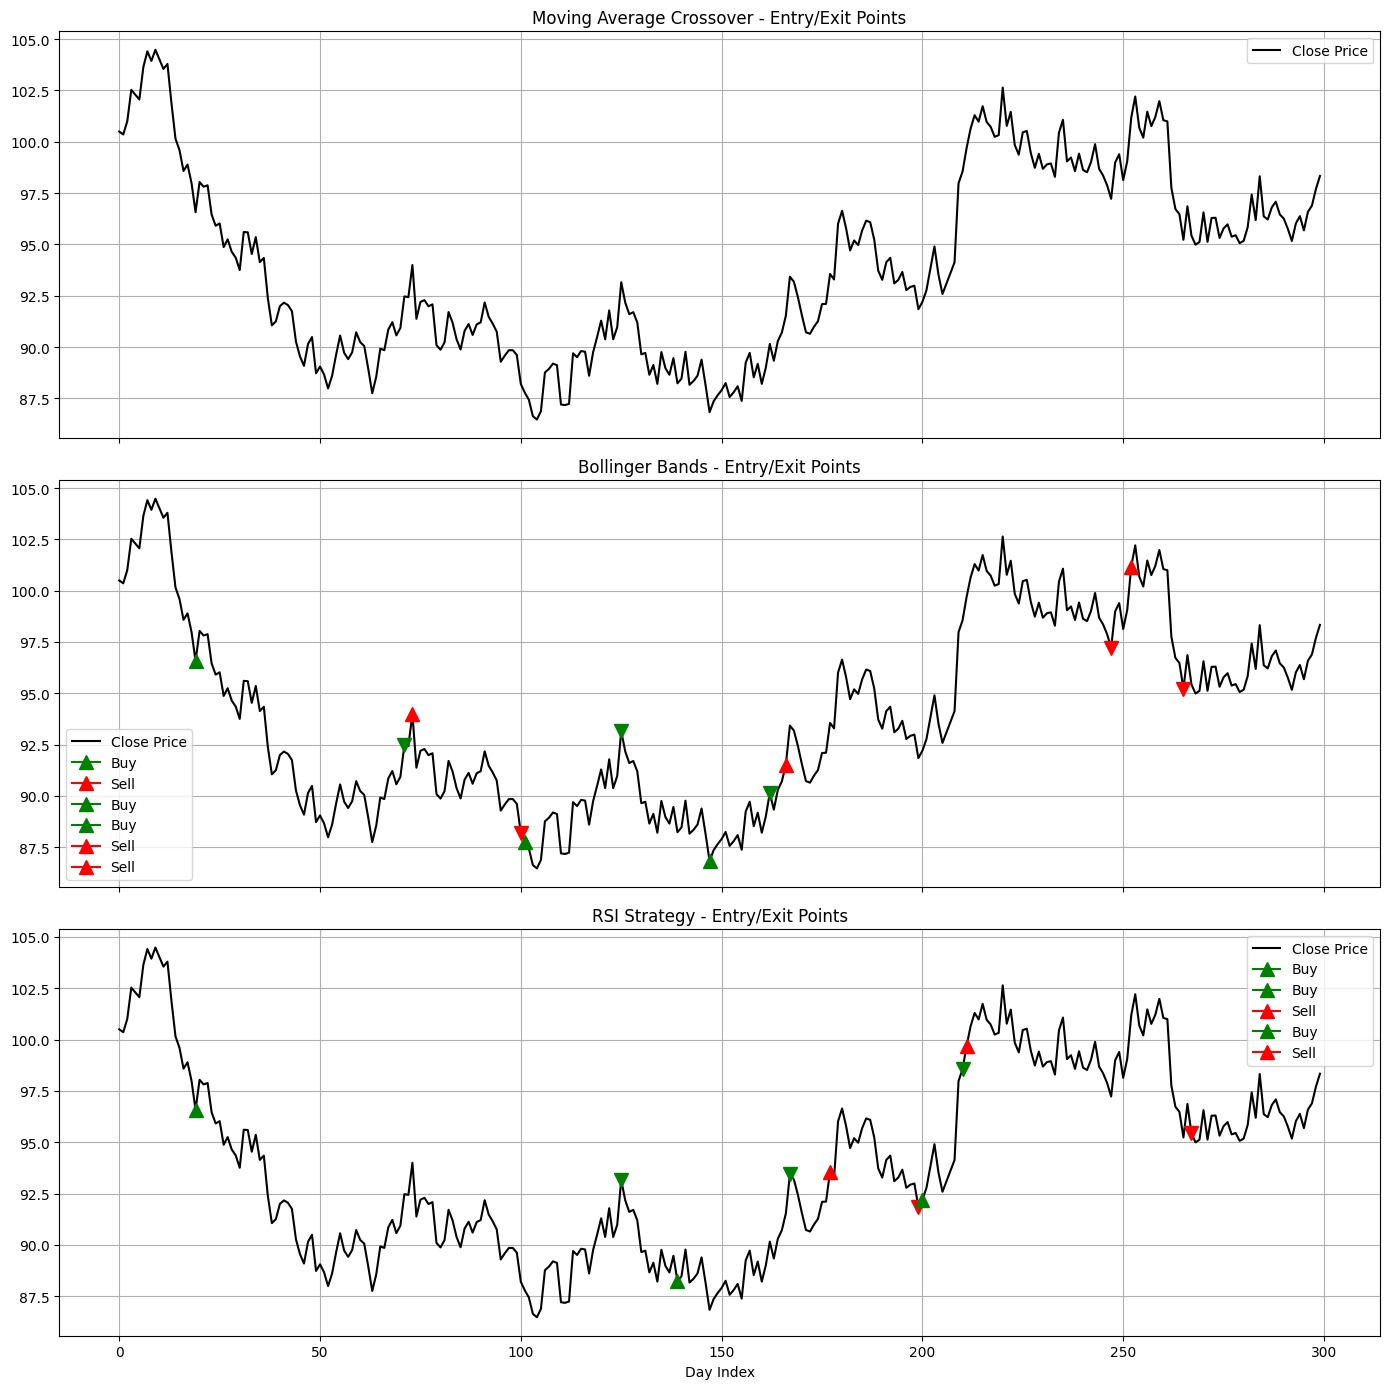

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data
np.random.seed(42)
n = 300
prices = np.cumsum(np.random.randn(n)) + 100
data = pd.DataFrame({'Close': prices})

# Step 2: Indicator Calculation
def calculate_indicators(data):
    # Moving Averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()
    data['MACrossover'] = np.where(
        (data['MA_50'] > data['MA_200']) & (data['MA_50'].shift(1) <= data['MA_200'].shift(1)), 1,
        np.where((data['MA_50'] < data['MA_200']) & (data['MA_50'].shift(1) >= data['MA_200'].shift(1)), -1, 0)
    )

    # Bollinger Bands
    window = 20
    data['MA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['UpperBand'] = data['MA'] + 2 * data['STD']
    data['LowerBand'] = data['MA'] - 2 * data['STD']
    data['BBSignal'] = np.where(data['Close'] < data['LowerBand'], 1,
                        np.where(data['Close'] > data['UpperBand'], -1, 0))

    # RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    data['RSISignal'] = np.where(data['RSI'] < 30, 1,
                          np.where(data['RSI'] > 70, -1, 0))

    return data

data = calculate_indicators(data)

# Step 3: Track actual trades
def get_trade_points(data, signal_column):
    trades = []
    position = None
    for i in range(len(data)):
        signal = data[signal_column].iloc[i]
        price = data['Close'].iloc[i]
        if position is None:
            if signal in [1, -1]:
                entry_index = i
                entry_price = price
                position = signal
        else:
            if (position == 1 and signal == -1) or (position == -1 and signal == 1):
                exit_index = i
                exit_price = price
                trades.append((entry_index, exit_index, position))
                position = None
    return trades

# Step 4: Get trade points for each strategy
ma_trades = get_trade_points(data, 'MACrossover')
bb_trades = get_trade_points(data, 'BBSignal')
rsi_trades = get_trade_points(data, 'RSISignal')

# Step 5: Plot Entry and Exit Points
fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

def plot_trades(ax, trades, title):
    ax.plot(data['Close'], label='Close Price', color='black')
    for entry, exit, pos in trades:
        color = 'green' if pos == 1 else 'red'
        ax.plot(entry, data['Close'].iloc[entry], marker='^', color=color, markersize=10, label='Buy' if pos == 1 else 'Sell')
        ax.plot(exit, data['Close'].iloc[exit], marker='v', color=color, markersize=10)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

plot_trades(axs[0], ma_trades, 'Moving Average Crossover - Entry/Exit Points')
plot_trades(axs[1], bb_trades, 'Bollinger Bands - Entry/Exit Points')
plot_trades(axs[2], rsi_trades, 'RSI Strategy - Entry/Exit Points')

plt.xlabel('Day Index')
plt.tight_layout()
plt.show()


Final capital for Moving Average crossover strategy: 1850.98
Final capital for Bollinger Bands strategy: 18579.9
Final capital for RSI strategy: 28479.31
Total Trades (MA, BB, RSI): 299 34 120


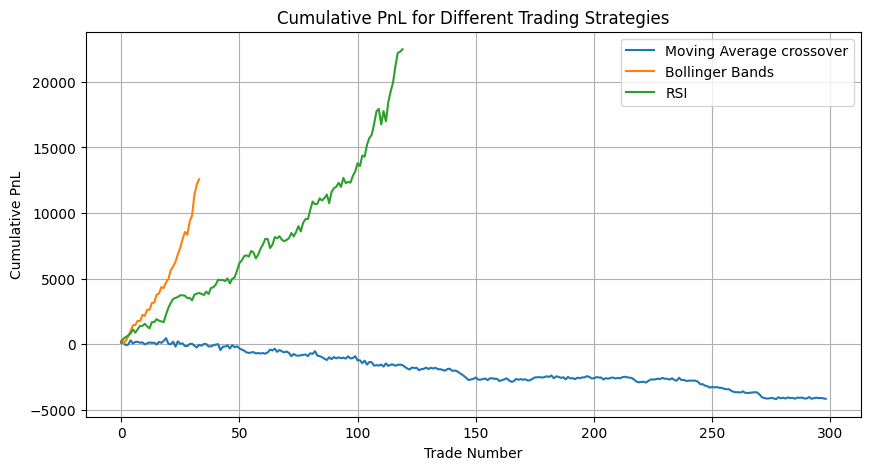

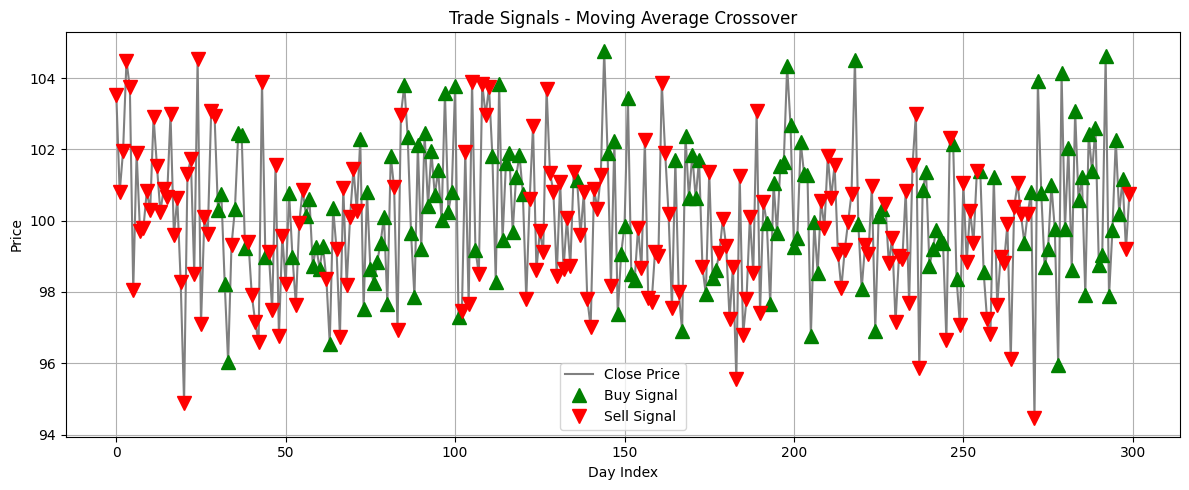

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Technical Indicator Calculation ===
def calculate_indicators(data):
    # Moving Average Crossover (10 & 20)
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['MACrossover'] = np.where(data['MA_10'] > data['MA_20'], 1, -1)

    # Bollinger Bands (window = 10)
    window = 10
    data['MA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['UpperBand'] = data['MA'] + (data['STD'] * 1.5)
    data['LowerBand'] = data['MA'] - (data['STD'] * 1.5)
    data['BBSignal'] = np.where(data['Close'] < data['LowerBand'], 1,
                         np.where(data['Close'] > data['UpperBand'], -1, 0))

    # RSI (shorter window for more trades)
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=3).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=3).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    data['RSISignal'] = np.where(data['RSI'] > 70, -1,
                          np.where(data['RSI'] < 30, 1, 0))
    return data

# === Step 2: Backtesting Function ===
def backtest_strategy(data, signal_column, initial_capital=6000, hold_days=3):
    position = None
    capital = initial_capital
    pnl = []
    position_size = 0
    entry_price = 0
    entry_index = 0

    for i in range(len(data)):
        signal = data[signal_column].iloc[i]

        # Exit if max holding period is over
        if position is not None and (i - entry_index >= hold_days):
            exit_price = data['Close'].iloc[i]
            profit = (exit_price - entry_price) * position_size if position == 'long' else (entry_price - exit_price) * position_size
            pnl.append(profit)
            capital += profit
            position = None

        # Exit on opposite signal
        elif position is not None and signal != 0:
            exit_price = data['Close'].iloc[i]
            profit = (exit_price - entry_price) * position_size if position == 'long' else (entry_price - exit_price) * position_size
            pnl.append(profit)
            capital += profit
            position = None

        # Open a new trade
        if position is None and signal != 0:
            position = 'long' if signal == 1 else 'short'
            entry_price = data['Close'].iloc[i]
            position_size = capital / entry_price
            entry_index = i

    return capital, pnl

# === Step 3: Example Data ===
np.random.seed(0)
data = pd.DataFrame({'Close': np.random.normal(loc=100, scale=2, size=300)})

# === Step 4: Run Indicator Calculation ===
data = calculate_indicators(data)

# === Step 5: Backtest Strategies ===
capital_MA, pnl_MA = backtest_strategy(data, 'MACrossover')
capital_BB, pnl_BB = backtest_strategy(data, 'BBSignal')
capital_RSI, pnl_RSI = backtest_strategy(data, 'RSISignal')

# === Step 6: Print Results ===
print("Final capital for Moving Average crossover strategy:", round(capital_MA, 2))
print("Final capital for Bollinger Bands strategy:", round(capital_BB, 2))
print("Final capital for RSI strategy:", round(capital_RSI, 2))
print("Total Trades (MA, BB, RSI):", len(pnl_MA), len(pnl_BB), len(pnl_RSI))

# === Step 7: Plot Cumulative PnL ===
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pnl_MA), label='Moving Average crossover')
plt.plot(np.cumsum(pnl_BB), label='Bollinger Bands')
plt.plot(np.cumsum(pnl_RSI), label='RSI')
plt.title('Cumulative PnL for Different Trading Strategies')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

# === Step 8: Plot Buy/Sell Signals (MACrossover) ===
plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Close Price', color='gray')
plt.plot(data['Close'][data['MACrossover'] == 1], '^', markersize=10, label='Buy Signal', color='green')
plt.plot(data['Close'][data['MACrossover'] == -1], 'v', markersize=10, label='Sell Signal', color='red')
plt.title('Trade Signals - Moving Average Crossover')
plt.xlabel('Day Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
import pickle 
pickle_out = open("analyser.pkl","wb")
pickle.dump(data, pickle_out)
pickle_out.close()